In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Warning: Does contain spoilers.<br /><br />Open Your Eyes<br /><br />If you have not seen this film and plan on doing so, just stop reading here and take my word for it. You have to see this film. I have seen it four times so far and I still haven\'t made up my mind as to what exactly happened in the film. That is all I am going to say because if you have not seen this film, then stop reading right now.<br /><br />If you are still reading then I am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think.<br /><br />I remember my Grade 11 English teacher quite well. His name was Mr. Krisak. To me, he was wise beyond his years and he always had this circuitous way of teaching you things that perhaps you weren\'t all too keen on. If we didn\'t like Shakespeare, then he turned the story into a modern day romance with modern day language so we could understand it. Our class room was never a room, it was a cottage and

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 121,   1, ..., 948, 123, 516],
       [ 36,  11, 381, ...,   0,   0,   0],
       [ 15, 234,  15, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Warning: Does contain spoilers.<br /><br />Open Your Eyes<br /><br />If you have not seen this film and plan on doing so, just stop reading here and take my word for it. You have to see this film. I have seen it four times so far and I still haven\'t made up my mind as to what exactly happened in the film. That is all I am going to say because if you have not seen this film, then stop reading right now.<br /><br />If you are still reading then I am going to pose some questions to you and maybe if anyone has any answers you can email me and let me know what you think.<br /><br />I remember my Grade 11 English teacher quite well. His name was Mr. Krisak. To me, he was wise beyond his years and he always had this circuitous way of teaching you things that perhaps you weren\'t all too keen on. If we didn\'t like Shakespeare, then he turned the story into a modern day romance with modern day language so we could understand it. Our class room was never a room, it was a cottage a

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00629525]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 81ms/step
[0.00629525]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 100ms/step - loss: 0.6614 - accuracy: 0.5441 - val_loss: 0.5598 - val_accuracy: 0.6932
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4597 - accuracy: 0.7733 - val_loss: 0.3849 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3587 - accuracy: 0.8395 - val_loss: 0.3389 - val_accuracy: 0.8510
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3264 - accuracy: 0.8568 - val_loss: 0.3251 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3157 - accuracy: 0.8618 - val_loss: 0.3324 - val_accuracy: 0.8354
Epoch 6/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3080 - accuracy: 0.8654 - val_loss: 0.3207 - val_accuracy: 0.8464
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3024 - accuracy: 0.8700 - val_loss: 0.3300 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3174 - accuracy: 0.8622
Test Loss: 0.31735706329345703
Test Accuracy: 0.8622000217437744


(0.0, 0.679695351421833)

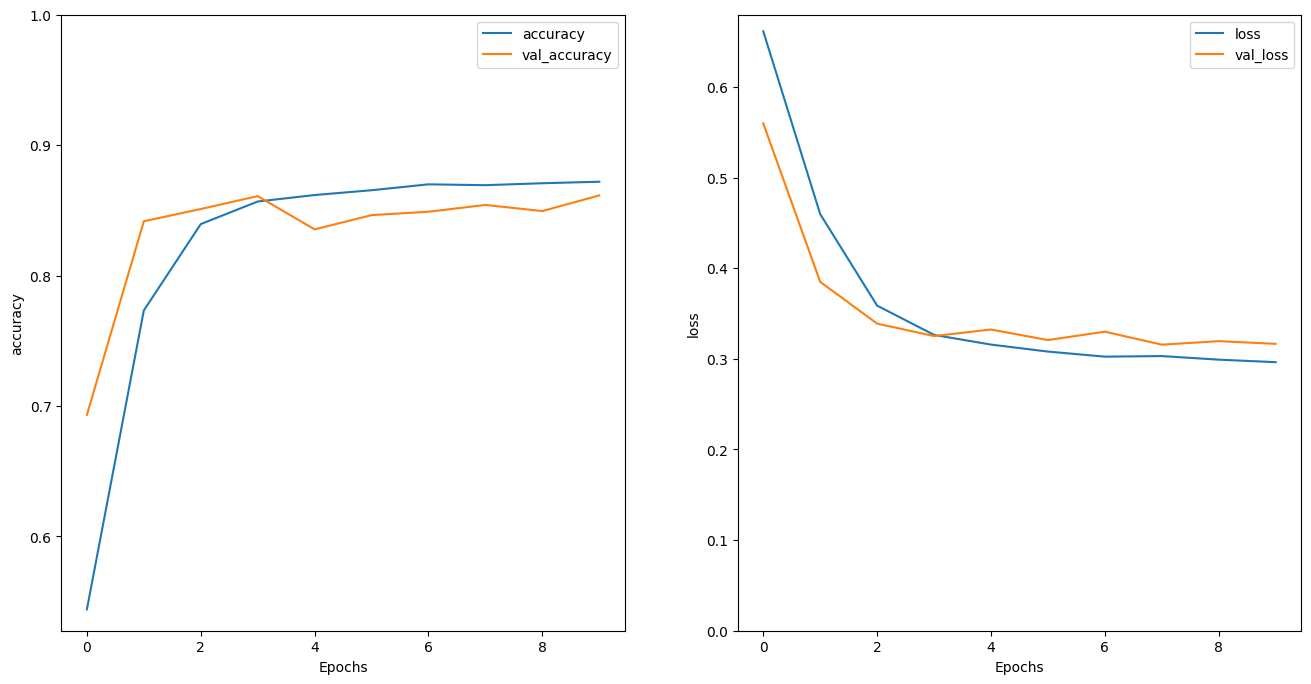

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics'
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 73s 143ms/step - loss: 0.6368 - accuracy: 0.5708 - val_loss: 0.4624 - val_accuracy: 0.7849
Epoch 2/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3905 - accuracy: 0.8306 - val_loss: 0.3702 - val_accuracy: 0.8490
Epoch 3/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3479 - accuracy: 0.8521 - val_loss: 0.3578 - val_accuracy: 0.8328
Epoch 4/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3219 - accuracy: 0.8638 - val_loss: 0.3308 - val_accuracy: 0.8609
Epoch 5/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3148 - accuracy: 0.8669 - val_loss: 0.3420 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 42s 107ms/step - loss: 0.3110 - accuracy: 0.8664 - val_loss: 0.3328 - val_accuracy: 0.8411
Epoch 7/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3051 - accuracy: 0.8694 - val_loss: 0.3273 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 44ms/step - loss: 0.3219 - accuracy: 0.8550
Test Loss: 0.321933388710022
Test Accuracy: 0.8550400137901306


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.6965208]]


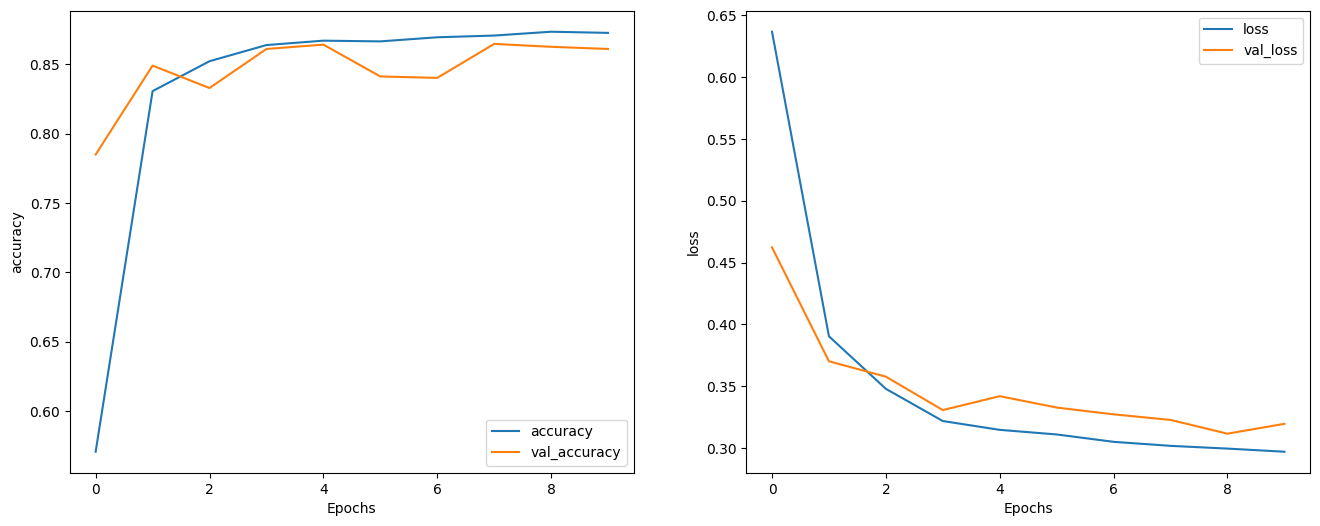

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')